**NOTE:** For all questions in this notebook, include your answers in the write pdf submission. Do **not** submit the colab.

# Homework 2

We will use the CIFAR-100 in this notebook, which has **100** classes. Unlike homework 1, we will instead use CNN models to investigate some interesting aspects of training deep models. Moreover, we will use standard PyTorch `nn.Module`s and `optim.Optimizer`s.

<h2>CIFAR-100</h2>

CIFAR-100  is a image classification dataset.
+ Each data sample is an RGB $32\times32$ real image. A raw loaded image $\in \mathbb{R}^{3 \times 32 \times 32}$.
+ Each image is associated with a label $\in \{0,1,2,\dots, 99\}$.


Our goal is to train a neural network classifier that takes such $3\times32\times32$ images and predict a label $\in \{0, 1, 2, \dots, 99\}$.

In [ ]:
# install dependencies

!pip install torch torchvision

You should run on GPU-enabled colab server (should be default for this notebook).

In [2]:
%matplotlib inline

from typing import *

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dataclasses
from tqdm.auto import tqdm

import torchvision
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
assert torch.cuda.is_available(), "Should use GPU-enabled colab"

device = torch.device('cuda:0')  # we will train with CUDA!

c:\Users\moumo\anaconda3\envs\dl_psets\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

Let's reuse the homework 1 augmented dataset code, but now modified to work on **CIFAR-100**. Code is hidden in the cell below, but make sure to still run it.

100%|██████████| 169001437/169001437 [00:09<00:00, 17677992.32it/s]


Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Training set size: 50000
Validation set size: 10000
CIFAR-100 classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sun

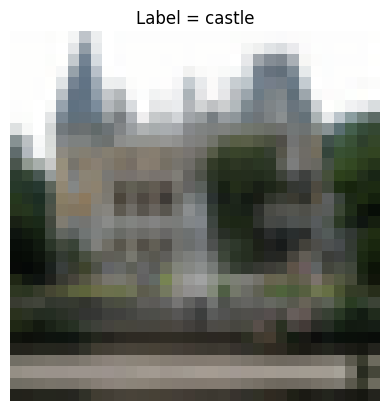

In [3]:
#@title
%matplotlib inline

import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def get_datasets(train_transforms=(), val_transforms=()):
    r"""
    Returns the CIFAR-100 training and validation datasets with corresponding
    transforms.

    `*_transforms` represent optional transformations, e.g., conversion to
    PyTorch tensors, preprocessing, etc.
    """
    train_set = torchvision.datasets.CIFAR100(
        './data', train=True, download=True,
        transform=torchvision.transforms.Compose(train_transforms))
    val_set = torchvision.datasets.CIFAR100(
        './data', train=False, download=True,
        transform=torchvision.transforms.Compose(val_transforms))
    return train_set, val_set


cifar100_mean = torch.as_tensor([0.5071, 0.4865, 0.4409])
cifar100_std = torch.as_tensor([0.2673, 0.2564, 0.2762])

train_transforms = [
    torchvision.transforms.RandomCrop(32, padding=3, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=cifar100_mean, std=cifar100_std),
]

val_transforms = [
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=cifar100_mean, std=cifar100_std),
]

train_set, val_set = get_datasets(train_transforms, val_transforms)

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")

class_names = train_set.classes
print(f'CIFAR-100 classes: {class_names}')

def visualize_tensor_data(data: torch.Tensor, label: int):
    # Data is a tensor of shape [C, W, H]  (C is the channel dimension, 3 for RGB)
    # Put channel at last
    data = data.permute(1, 2, 0)
    # Un-normalize
    data = data * cifar100_std + cifar100_mean

    plt.imshow(data)
    plt.axis('off')
    plt.title(f'Label = {class_names[label]}')

data, label = train_set[13]
visualize_tensor_data(data, label)


## Network Definition

**Question 5**: Implement the following function that creates the specified CNN networks. Read through the docstring and make sure that your implementation behaves as required. Afterwards, print the outputs of
+ `make_cnn(100, 'tanh', num_conv_layers=5, num_fc_layers=4)`
+ `make_cnn(3, 'none', num_conv_layers=3, num_fc_layers=2)`

Add both your implementation and outputs to the writeup.

---

Links you may find useful:
+ `none` activation: https://pytorch.org/docs/stable/generated/torch.nn.Identity.html?highlight=identity#torch.nn.Identity
+ Chaining layers: https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html?highlight=sequential#torch.nn.Sequential
+ Reshaping image-like tensors to vectors: https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten

(You are not required to use these classes)

In [4]:
def make_mlp(
    num_inputs: int, num_outputs: int, activation: str, hidden_sizes: int = [128]
) -> nn.Module:


    if activation == "relu":

        act_cls = nn.ReLU

    elif activation == "tanh":

        act_cls = nn.Tanh

    elif activation == "none":

        act_cls = nn.Identity
    else:


        raise ValueError(f"Unexpected activation={repr(activation)}")


    net = [nn.Flatten(), nn.Linear(num_inputs, hidden_sizes[0]), act_cls()]


    for i in range(1, len(hidden_sizes)):

        net.extend([nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]), act_cls()])

    net.extend([nn.Linear(hidden_sizes[-1], num_outputs)])


    return nn.Sequential(*net)

In [8]:
def make_cnn(
    num_outputs: int, activation: str, num_conv_layers: int = 4, num_fc_layers: int = 2
) -> nn.Module:
    r"""





    Returns a PyTorch module representing a CNN network that takes in image-like input with shape [3, 32, 32].





    Args:





        num_outputs (int): size of the final output layer. E.g., if the network is a classifier, this is usually #classes.





        activation (str): activation functions between conv/linear layers. Supported choices are ['relu', 'tanh', 'none'] (always strings).





            For 'none', no activation function is applied, and the previous conv/linear output is directly fed into the next conv/linear.





        num_conv_layers (int): number of conv layers in CNN. This should be >= 3 and <= 5.





            First conv layer should always use 5x5 kernels, mapping 3-channel data to 12-channel data, with **reflect** padding=2 and no striding.





            Subsequent conv layers should always use 3x3 kernels, mapping to 64-channel data, with zeros (default) padding=1 and strides=2.





        num_fc_layers (int): number of fc/linear layers after the convolutional part. This should be >= 2.




            For all but the last fc layer, it should output 128-dimensional vectors.





    Returns:





        (nn.Module) The CNN network of desired tructure.





    If an unexpected input is given, this will raise a ValueError. (You can assume that arguments are of correct types.)





    """


    # FIXME

    if activation == "relu":
        act_cls = nn.ReLU
    elif activation == "tanh":
        act_cls = nn.Tanh
    elif activation == "none":
        act_cls = nn.Identity
    else:
        raise ValueError(f"Unexpected activation={repr(activation)}")
    net = [
        nn.Conv2d(
            in_channels=3,
            out_channels=12,
            kernel_size=5,
            padding_mode="reflect",
            padding=2,
            stride=1,
        ),
        act_cls(),
    ]
    num_out = 12
    for _ in range(num_conv_layers - 1):
        net.extend(
            [
                nn.Conv2d(
                    in_channels=num_out,
                    out_channels=64,
                    kernel_size=3,
                    padding=1,
                    stride=2,
                ),
                act_cls(),
            ]
        )
        num_out = 64
    net.extend([nn.Flatten()])
    for _ in range(num_fc_layers - 1):
        net.extend([nn.LazyLinear(out_features=128), act_cls()])
    net.extend([nn.LazyLinear(out_features=num_outputs)])
    return nn.Sequential(*net)

In [9]:
print("num_outputs=100, tanh, hidden_sizes=[128, 120]")
print(make_mlp(10, 100, "tanh", hidden_sizes=[128, 120]))
print()
print("num_outputs=100, tanh, num_conv_layers=5, num_fc_layers=4:")
print(make_cnn(100, "tanh", num_conv_layers=5, num_fc_layers=4))
print()
print("num_outputs=3, no activation, num_conv_layers=3, num_fc_layers=2:")
print(make_cnn(3, "none", num_conv_layers=3, num_fc_layers=2))

num_outputs=100, tanh, hidden_sizes=[128, 120]
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=10, out_features=128, bias=True)
  (2): Tanh()
  (3): Linear(in_features=128, out_features=120, bias=True)
  (4): Tanh()
  (5): Linear(in_features=120, out_features=100, bias=True)
)

num_outputs=100, tanh, num_conv_layers=5, num_fc_layers=4:
Sequential(
  (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=reflect)
  (1): Tanh()
  (2): Conv2d(12, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): Tanh()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Tanh()
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): Tanh()
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): Tanh()
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): LazyLinear(in_features=0, out_features=128, bias=True)
  (12): Tanh()
  (13): LazyLinear(in_features=0, out_feature

## Training loop

**Question 6**: Implement the following training and evaluate functions according to docstring. Complete the `FIXME`s in `train_epoch`, `evaluate`, and `train`. Attach your code to PDF.

---

Links you may find useful:
+ Classification loss: https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html?highlight=cross_entropy#torch.nn.functional.cross_entropy
+ Learning rate adjustment: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

(You are not required to use these classes)

In [18]:
def train_epoch(
    epoch: int,
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    optim: torch.optim.Optimizer,
):
    r"""







    Trains `model` on `train_loader` for cross entropy loss for one epoch.







    Args:






        epoch (int): the current epoch number (i.e., number of epochs done before this one).






        model (nn.Module): our network (created using `make_cnn`).






        train_loader (DataLoader): a DataLoader that yields (batched_images, batched_target_class_indices) when iterated.






        optim (Optimizer): optimizer object that is created with `model` parameters and should be used for updating `model` in this function.






    Returns:






        (List[float]) the losses computed at each iteration as a list of *Python* numbers.






    NOTE:






      + Remember to clear previously computed gradient at beginning of each iteration.






      + Convert loss values to python floats (e.g., via `.item()`) before adding to `loss_values`.






    """

    loss_values: List[float] = []

    loss_fn = nn.CrossEntropyLoss()

    for data, target in tqdm(train_loader, desc=f"Training @ epoch {epoch}"):
        optim.zero_grad()
        data = data.to(device)
        target = target.to(device)
        # make predictions
        prediction = model(data)

        # compute loss
        loss = loss_fn(input=prediction, target=target)
        loss_values.append(loss.item())
        loss.backward()
        optim.step()

    return loss_values



@dataclasses.dataclass
class EvaluateResult:
    r"""




    A collection containing everything we need to know about the evaluate results.




    See `evaluate` docstring for meanings of the members of this class




    """

    acc: float  # overall accuracy

    correct_predictions: torch.Tensor  # size |dataset|

    confidence: torch.Tensor  # size |dataset|



@torch.no_grad()
def evaluate(model: nn.Module, loader: torch.utils.data.DataLoader) -> EvaluateResult:
    r"""



    Evaluate a classifier `model` on dataset contained in `loader`.



    For each input, the predicted label is taken as one with highest probability in the distribution given by `model`.



    In addition to compute overall accuracies, we also output



        (1) a boolean Tensor with size |dataset|, showing whether each sample is correctly classified.



        (2) a float32 Tensor with size |dataset|, showing the `model`'s assigned probability for its prediction, called *confidence*.



    Args:



        model (nn.Module): our network (created using `make_cnn`).



        loader (DataLoader): a DataLoader that yields (batched_images, batched_target_class_indices) when iterated.



    Returns:



        (EvaluateResult) Containing overall accuracy, whether each sample is correctly classified, and confidence.



            The tensors should be on **CPU**.



    """


    # FIXME

    correct_predictions = []
    confidence = []
    model.eval()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        prob = torch.softmax(output, dim=1)
        pred = torch.argmax(prob, dim=1)
        conf = torch.max(prob, dim=1).values
        correct_predictions.append((pred == target).detach().cpu())
        confidence.append(conf.detach().cpu())

    correct_predictions = torch.cat(correct_predictions).cpu()
    confidence = torch.cat(confidence).cpu()
    acc = correct_predictions.float().mean().item()
    eval_result = EvaluateResult(acc, correct_predictions, confidence)
    return eval_result



@dataclasses.dataclass
class TrainResult:
    r"""


    A collection containing everything we need to know about the training results


    """

    num_epochs: int

    # Training loss (saved at each iteration in `train_epoch`)
    train_losses: List[float]

    # The epochs where we perform evaluation
    eval_epochs: List[int]

    # Training accuracies, computed at each epoch in `eval_epochs`
    train_accs: List[float]

    # Validation accuracies, computed at each epoch in `eval_epochs`
    val_accs: List[float]

    # The last validation evaluation full result

    final_val_eval_result: EvaluateResult = None



def train(
    model: nn.Module,
    train_set,
    val_set,
    *,
    num_epochs=60,
    lr=0.003,
    train_epoch_fn=train_epoch,
    **kwargs,
):
    r"""


    Train `model` on `train_set` for `num_epochs` epochs using **Adam** optimizer and `lr` learning rate


    following a decay schedule by a factor of `0.3` at epochs `[5, 50]`.


    Args:


        model (nn.Module): our network (created using `make_cnn`).


        train_set (Dataset): CIFAR-100 training dataset.


        val_set (Dataset): CIFAR-100 validation dataset. Evaluated every *5* epochs and at the end of training.


        num_epochs (int): number of total training epochs.


        lr (float): initial learning rate.


        train_epoch_fn (Callable): function that trains the model for a single epoch. This is `train_epoch`

            usually, but we will use different choices in later questions.


    Returns:


        (TrainResult)


    """

    # Data loaders

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=512, shuffle=True
    )  # Random order for training ("[S]tochastic" in SGD)

    val_loader = torch.utils.data.DataLoader(val_set, batch_size=1024, shuffle=False)


    # Our classifier

    print("Model =", model)


    # Create optimizer and lr scheduler

    # FIXME

    optim = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optim, milestones=[5, 50], gamma=0.3
    )


    result: TrainResult = TrainResult(
        num_epochs, train_losses=[], eval_epochs=[], train_accs=[], val_accs=[]
    )

    last_eval_epoch = -float("inf")


    # Iterate through the entire training dataset `num_epochs` times

    for epoch in range(num_epochs):

        if epoch - last_eval_epoch >= 5:

            result.eval_epochs.append(epoch)

            result.train_accs.append(evaluate(model, train_loader).acc)

            result.val_accs.append(evaluate(model, val_loader).acc)

            print(
                f"Epoch = {epoch:> 2d}    Train acc = {result.train_accs[-1]:.2%}    Val acc = {result.val_accs[-1]:.2%}"
            )

            last_eval_epoch = epoch

        # Train over the entire `train_set` with given `train_epoch_fn` function (i.e., one epoch)

        result.train_losses.extend(
            train_epoch_fn(epoch, model, train_loader, optim, **kwargs)
        )

        # Evaluate with our `evaluate` function

        print(f"Epoch = {epoch:> 2d}    Train loss = {result.train_losses[-1]:.4f}")


        # Adjust learning rate if needed

        scheduler.step()


    result.eval_epochs.append(num_epochs)

    result.train_accs.append(evaluate(model, train_loader).acc)

    result.final_val_eval_result = evaluate(model, val_loader)

    result.val_accs.append(result.final_val_eval_result.acc)

    print(
        f"Epoch = {num_epochs:> 2d}    Train acc = {result.train_accs[-1]:.2%}    Val acc = {result.val_accs[-1]:.2%}"
    )

    return result

We provide the following learning curve plotting function (similar to homework 1).

In [12]:
def learning_curve(result: TrainResult, *, title: str = "Learning Curve"):
    r"""
    Plot the training loss, training accuracy, and validation accuracy versus
    epochs taken.
    """
    fig, ax_loss = plt.subplots(figsize=(8, 5))
    ax_loss.set_title(title, fontsize=16)
    ax_loss.set_xlabel("Epoch", fontsize=12)

    l_trloss = ax_loss.plot(
        torch.arange(len(result.train_losses))
        / len(result.train_losses)
        * result.num_epochs,
        result.train_losses,
        label="Train loss",
        color="C0",
    )
    ax_loss.set_ylim(0, 4.8)
    ax_loss.set_ylabel("Train loss", color="C0", fontsize=12)
    ax_loss.tick_params(axis="y", labelcolor="C0")

    ax_acc = ax_loss.twinx()
    l_tracc = ax_acc.plot(
        result.eval_epochs,
        result.train_accs,
        label="Train acc",
        color="C1",
        linestyle="--",
    )
    if len(result.val_accs):
        l_valacc = ax_acc.plot(
            result.eval_epochs, result.val_accs, label="Val acc", color="C1"
        )
    else:
        l_valacc = []
    ax_acc.set_ylim(0, 1)
    ax_acc.set_ylabel("Accuracies", color="C1", fontsize=12)
    ax_acc.tick_params(axis="y", labelcolor="C1")

    lines = l_trloss + l_tracc + l_valacc
    ax_loss.legend(lines, [l.get_label() for l in lines], loc="upper left", fontsize=13)

In [20]:
# Create a MLP 128 width, 3 depth on the GPU, train it, and plot learning curves.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_tensor_size = train_set[0][0].numel()
class_num = len(train_set.classes)
print(img_tensor_size, class_num)
model_MLP = make_mlp(img_tensor_size, class_num, "relu", [128, 128, 128])
model_MLP = model_MLP.to(device)
result_mlp = train(model_MLP, train_set, val_set, num_epochs=20, lr=0.15)
# train

3072 100
Model = Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=128, bias=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=100, bias=True)
)
Epoch =  0    Train acc = 0.84%    Val acc = 0.70%


Training @ epoch 0: 100%|██████████| 98/98 [00:11<00:00,  8.39it/s]


Epoch =  0    Train loss = 4.6138


Training @ epoch 1: 100%|██████████| 98/98 [00:11<00:00,  8.58it/s]


Epoch =  1    Train loss = 4.6193


Training @ epoch 2: 100%|██████████| 98/98 [00:11<00:00,  8.79it/s]


Epoch =  2    Train loss = 4.6171


Training @ epoch 3: 100%|██████████| 98/98 [00:11<00:00,  8.46it/s]


Epoch =  3    Train loss = 4.6199


Training @ epoch 4: 100%|██████████| 98/98 [00:11<00:00,  8.50it/s]


Epoch =  4    Train loss = 4.6202
Epoch =  5    Train acc = 1.00%    Val acc = 1.00%


Training @ epoch 5: 100%|██████████| 98/98 [00:11<00:00,  8.40it/s]


Epoch =  5    Train loss = 4.6169


Training @ epoch 6: 100%|██████████| 98/98 [00:11<00:00,  8.43it/s]


Epoch =  6    Train loss = 4.6175


Training @ epoch 7: 100%|██████████| 98/98 [00:11<00:00,  8.66it/s]


Epoch =  7    Train loss = 4.5999


Training @ epoch 8: 100%|██████████| 98/98 [00:11<00:00,  8.42it/s]


Epoch =  8    Train loss = 4.6161


Training @ epoch 9: 100%|██████████| 98/98 [00:11<00:00,  8.76it/s]


Epoch =  9    Train loss = 4.6131
Epoch =  10    Train acc = 1.00%    Val acc = 1.00%


Training @ epoch 10: 100%|██████████| 98/98 [00:11<00:00,  8.50it/s]


Epoch =  10    Train loss = 4.6149


Training @ epoch 11: 100%|██████████| 98/98 [00:11<00:00,  8.54it/s]


Epoch =  11    Train loss = 4.6100


Training @ epoch 12: 100%|██████████| 98/98 [00:11<00:00,  8.55it/s]


Epoch =  12    Train loss = 4.5982


Training @ epoch 13: 100%|██████████| 98/98 [00:11<00:00,  8.56it/s]


Epoch =  13    Train loss = 4.6067


Training @ epoch 14: 100%|██████████| 98/98 [00:11<00:00,  8.51it/s]


Epoch =  14    Train loss = 4.6173
Epoch =  15    Train acc = 1.00%    Val acc = 1.00%


Training @ epoch 15: 100%|██████████| 98/98 [00:11<00:00,  8.81it/s]


Epoch =  15    Train loss = 4.6121


Training @ epoch 16: 100%|██████████| 98/98 [00:10<00:00,  8.94it/s]


Epoch =  16    Train loss = 4.6160


Training @ epoch 17: 100%|██████████| 98/98 [00:11<00:00,  8.88it/s]


Epoch =  17    Train loss = 4.6105


Training @ epoch 18: 100%|██████████| 98/98 [00:11<00:00,  8.80it/s]


Epoch =  18    Train loss = 4.6146


Training @ epoch 19: 100%|██████████| 98/98 [00:11<00:00,  8.55it/s]


Epoch =  19    Train loss = 4.6082
Epoch =  20    Train acc = 1.00%    Val acc = 1.00%


In [ ]:
# Create a MLP 128 width, 7 depth on the GPU, train it, and plot learning curves.
model_MLP2 = make_mlp(
    img_tensor_size, class_num, "relu", [128, 128, 128, 128, 128, 128, 128]
)
model_MLP2 = model_MLP2.to(device)
result_mlp2 = train(model_MLP2, train_set, val_set, num_epochs=20, lr=0.15)

In [22]:
# Create a CNN 4 convolutional layers, 3 MLP layers on the GPU, train it, and plot learning curves.
model_CNN = make_cnn(class_num, "relu", 4, 3)
model_CNN = model_CNN.to(device)
result_cnn = train(model_CNN, train_set, val_set, num_epochs=20, lr=0.15)

Model = Sequential(
  (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=reflect)
  (1): ReLU()
  (2): Conv2d(12, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): LazyLinear(in_features=0, out_features=128, bias=True)
  (10): ReLU()
  (11): LazyLinear(in_features=0, out_features=128, bias=True)
  (12): ReLU()
  (13): LazyLinear(in_features=0, out_features=100, bias=True)
)
Epoch =  0    Train acc = 1.00%    Val acc = 1.00%


Training @ epoch 0: 100%|██████████| 98/98 [00:12<00:00,  7.96it/s]


Epoch =  0    Train loss = 4.6131


Training @ epoch 1: 100%|██████████| 98/98 [00:11<00:00,  8.23it/s]


Epoch =  1    Train loss = 4.6241


Training @ epoch 2:  64%|██████▍   | 63/98 [00:07<00:04,  8.11it/s]


KeyboardInterrupt: 